<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2010%20-CNN%20Applications%20and%20Tricks/Lecture_10_CNN_Applications_and_Tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Convolutional Neural Networks



In [ ]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn import metrics

#To ensure reproducibility
#we set the random seed
seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)


In [ ]:
#Auxiliary Function to plot images side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)
    
  for i in range(n):         
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#Plot dataset samples
def plot_dataset(ds, lbls_name):
  N_SAMPLES = 10
  for i in range(5):
    for x,y in ds.take(1):    
      
      x = x.numpy()
      x = np.squeeze(x)      
      y = y.numpy()
      plot_sidebyside(x[:N_SAMPLES],
                      y[:N_SAMPLES],'gray')

#Plot a training history
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


# Datasets

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
!wget $dataset_url -O flower_photos.tgz


In [ ]:
!tar -xzf flower_photos.tgz
data_dir = 'flower_photos/'
!ls $data_dir

image_count = len(list(glob.glob(data_dir + '*/*.jpg')))
print(f'The dataset has {image_count} images')

In [ ]:
batch_size_ = 32
input_shape_ = (180,180,3)

ds_train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

ds_val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)
for img,lbl in train_ds.take(5):
  
  titles = []
  for i in lbl:    
    titles.append(class_names[lbl[i]])

  plot_sidebyside(img[:5]/255.,titles[:5])

#The Convolutional Layers
  As stated in the last class, a cnn model enqueue several convolutional layers. This step is called 'feature extraction'. In the end of this structure, the resulting matrix is a feature map with dense representations

  Lets see how to code it!

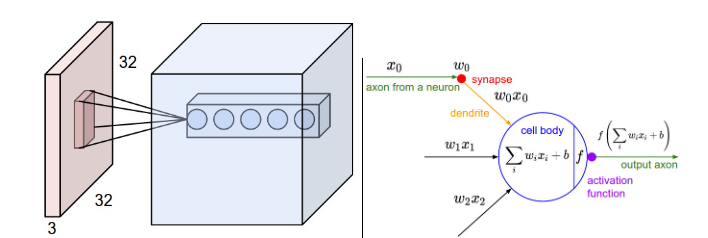


Additional Reference: https://cs231n.github.io/convolutional-networks/

To better illustrate, lets visualize a 5-layer CNN

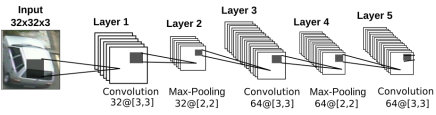

The respective implementation follows:




In [ ]:
model = models.Sequential()

#32 layers of size 3x3 and Relu Activation
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
#Max Pooling of Size (2x2)
model.add(layers.MaxPooling2D((2, 2)))


#64 layers of size 3x3 and Relu Activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#Max Pooling of Size (2x2)
model.add(layers.MaxPooling2D((2, 2)))

#64 layers of size 3x3 and Relu Activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

#The Fully Connected Layer
  The fully connected layer (FC) is a dense layer that receives a 1D tensor. It will provide predictions and probabilities. This is the classification step in the pipeline and can be replaced for another model. (SVM, etc.)

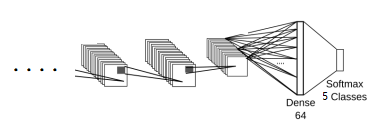

The last layer is a softmax activation

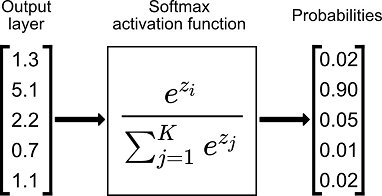

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

#Training

In [ ]:
epochs_ = 20
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(ds_train, batch_size=batch_size_, epochs=epochs_, validation_data=ds_val)

In [ ]:
plot_history(history)

##Evaluation



In [ ]:
def performance_evaluation(y_test, predictions,info_message,figsize=(18, 4)):
  
  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predictions)}\n")
  print(class_names)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()
  



In [ ]:
predictions = model.predict(ds_val)
y_test = tf.concat([y for x, y in ds_val], axis=0)
predictions = np.argmax(predictions,axis=1)
performance_evaluation(y_test,predictions,'Flowers')

##Visualizing Learned Filters and Feature Maps

In [ ]:
for i in range(len(model.layers[1:])):    
    layer = model.layers[i+1]
    if 'conv' not in layer.name:
        continue 

    filters , _ = layer.get_weights()
    
    print(f'### {layer.name} - {filters.shape} ###')
        
    #minmax normalization 
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    n_filters = 6
    
    ix=1
    fig = plt.figure(figsize=(6,6))
    
    for i in range(n_filters):        
        f = filters[:,:,:,i]        
        for j in range(6):            
            plt.subplot(n_filters,6,ix)
            plt.imshow(f[:,:,j] ,cmap='gray')
            plt.axis('off')
            ix+=1

    #plot the filters 
    plt.show()
    print('-----------------')

In [ ]:
for x,y in ds_test.take(1):
  x_test = x.numpy()

for i in range(len(model.layers[1:])):
    
    layer = model.layers[i+1]

    if 'conv' not in layer.name:
        continue 

    filters , _ = layer.get_weights()
   
    print(f'### {layer.name} - {filters.shape} ###')
    model_ = Model(inputs=model.inputs , outputs=model.layers[i].output)
    features = model_.predict(x_test[3:4])
    fig = plt.figure(figsize=(20,15))
    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(features[0,:,:,i-1] , cmap='gray')
        
    plt.show()

#Pratice 01:
  Now it's up to you. Try the other datasets and architectures available in this notebook. The rationale here is to understand the CNN background, different challenges, and deep networks

#Pratice 02:
  Evaluate the Simpsons dataset [https://bit.ly/3yQnFKA]
* Does CNN correctly recognize?
* Try to guess what is happening? Overfitting? Few Samples? Imbalanced Classes?
* How can we approach this dataset correctly?



